In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [5]:
customers = pd.read_csv('customers.csv')
products  = pd.read_csv('products.csv')
transactions  = pd.read_csv('transactions.csv')

In [6]:
# Preprocessing
customer_transactions = transactions.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    unique_products=('ProductID', 'nunique'),
    purchase_frequency=('TransactionID', 'count')
).reset_index()
print(customer_transactions)

    CustomerID  total_spent  total_quantity  unique_products  \
0        C0001      3354.52              12                5   
1        C0002      1862.74              10                4   
2        C0003      2725.38              14                4   
3        C0004      5354.88              23                8   
4        C0005      2034.24               7                3   
..         ...          ...             ...              ...   
194      C0196      4982.88              12                3   
195      C0197      1928.65               9                3   
196      C0198       931.83               3                2   
197      C0199      1979.28               9                4   
198      C0200      4758.60              16                5   

     purchase_frequency  
0                     5  
1                     4  
2                     4  
3                     8  
4                     3  
..                  ...  
194                   4  
195                   3

In [7]:
# Merge region data from Customers.csv
customer_profiles = pd.merge(customers, customer_transactions, on='CustomerID', how='right')
print(customer_profiles)

    CustomerID        CustomerName         Region  SignupDate  total_spent  \
0        C0001    Lawrence Carroll  South America  2022-07-10      3354.52   
1        C0002      Elizabeth Lutz           Asia  2022-02-13      1862.74   
2        C0003      Michael Rivera  South America  2024-03-07      2725.38   
3        C0004  Kathleen Rodriguez  South America  2022-10-09      5354.88   
4        C0005         Laura Weber           Asia  2022-08-15      2034.24   
..         ...                 ...            ...         ...          ...   
194      C0196         Laura Watts         Europe  2022-06-07      4982.88   
195      C0197    Christina Harvey         Europe  2023-03-21      1928.65   
196      C0198         Rebecca Ray         Europe  2022-02-27       931.83   
197      C0199      Andrea Jenkins         Europe  2022-12-03      1979.28   
198      C0200         Kelly Cross           Asia  2023-06-11      4758.60   

     total_quantity  unique_products  purchase_frequency  
0   

In [8]:
# Add product category preferences
transactions_products = pd.merge(transactions, products, on='ProductID', how='right')
category_preferences = transactions_products.groupby(['CustomerID', 'Category']).agg(
    category_spent=('TotalValue', 'sum')
).unstack(fill_value=0)
category_preferences.columns = [f"spent_on_{col[1]}" for col in category_preferences.columns]
customer_profiles = pd.merge(customer_profiles, category_preferences, on='CustomerID', how='left')

In [9]:
# Replace NaN values with 0 for missing transaction data
customer_profiles.fillna(0, inplace=True)

In [13]:
# Normalize features for similarity calculation
scaler = MinMaxScaler()
feature_columns = ['total_spent', 'total_quantity', 'unique_products', 'purchase_frequency'] + \
                  [col for col in customer_profiles.columns if col.startswith('spent_on_')]
normalized_features = scaler.fit_transform(customer_profiles[feature_columns])
features = normalized_features

In [14]:
# Try clustering with KMeans for 2 to 10 clusters and evaluate using DB Index
db_scores = []
silhouette_scores = []
cluster_results = {}

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features)
    
    # Calculate metrics
    db_index = davies_bouldin_score(features, labels)
    silhouette = silhouette_score(features, labels)
    db_scores.append(db_index)
    silhouette_scores.append(silhouette)
    
    # Store results for the best clusters
    cluster_results[n_clusters] = {
        'labels': labels,
        'db_index': db_index,
        'silhouette': silhouette,
        'centroids': kmeans.cluster_centers_
    }



In [15]:
# Find the best number of clusters based on the lowest DB Index
best_n_clusters = min(cluster_results, key=lambda x: cluster_results[x]['db_index'])
best_labels = cluster_results[best_n_clusters]['labels']
best_db_index = cluster_results[best_n_clusters]['db_index']


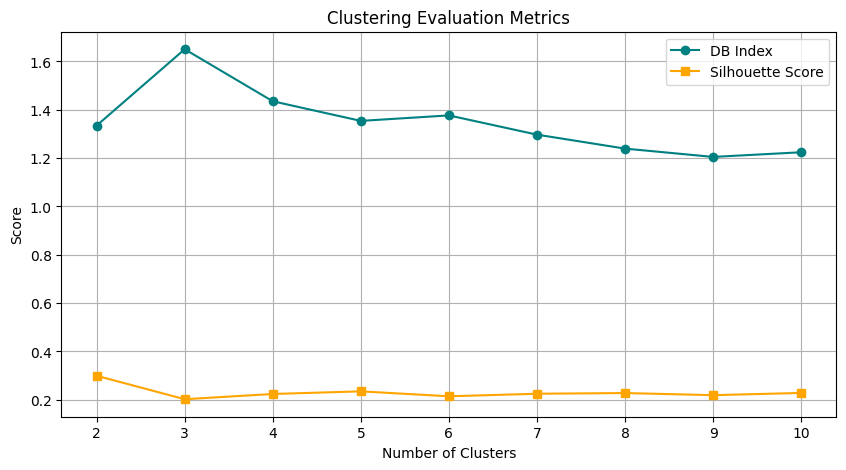

In [16]:
# Visualize the DB Index and Silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), db_scores, marker='o', label='DB Index', color='teal')
plt.plot(range(2, 11), silhouette_scores, marker='s', label='Silhouette Score', color='orange')
plt.title("Clustering Evaluation Metrics")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()


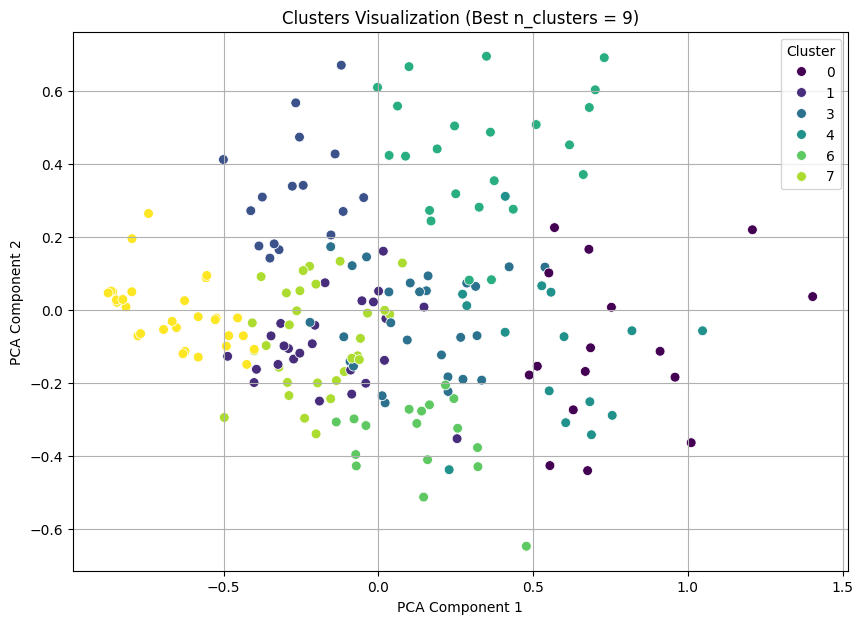

In [17]:
# Visualize clusters using PCA (2D)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=best_labels, palette='viridis', s=50)
plt.title(f"Clusters Visualization (Best n_clusters = {best_n_clusters})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.grid()
plt.show()


In [18]:
# Output best clustering results
best_n_clusters, best_db_index, cluster_results[best_n_clusters]['silhouette']

(9, 1.2050772975497883, 0.2193098787928863)